In [75]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa

try:
    %load_ext autotime
except:
    !pip install ipython-autotime
    %load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 2.93 ms (started: 2022-12-12 16:00:45 +01:00)


In [76]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)


time: 168 ms (started: 2022-12-12 16:00:45 +01:00)


In [77]:
def get_adversial_exemple(model, dataset, eps):
  adversarial_examples = []
  for images, labels in dataset:
    with tf.GradientTape() as tape:
      tape.watch(images)
      predictions = model(images)
      loss = tf.keras.losses.sparse_categorical_crossentropy(labels, predictions)
    gradient = tape.gradient(loss, images)
    signed_grad = tf.sign(gradient)
    adversarial_example = images + eps * signed_grad
    adversarial_example = tf.clip_by_value(adversarial_example, 0, 1)
    adversarial_examples.append(adversarial_example)
  adversarial_examples = np.concatenate(adversarial_examples,axis=0)
  return adversarial_examples


time: 878 µs (started: 2022-12-12 16:00:45 +01:00)


In [78]:
# Shallow softmax model

shallow_softmax = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(10, activation='softmax'),
])

shallow_softmax.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

shallow_softmax.fit(ds_train, epochs=5)
shallow_softmax.evaluate(ds_test)


Epoch 1/5
469/469 [==============================] - 4s 4ms/step - loss: 0.6765 - accuracy: 0.8343
Epoch 2/5
469/469 [==============================] - 2s 5ms/step - loss: 0.3618 - accuracy: 0.9019
Epoch 3/5
469/469 [==============================] - 2s 4ms/step - loss: 0.3190 - accuracy: 0.9125
Epoch 4/5
469/469 [==============================] - 2s 4ms/step - loss: 0.2995 - accuracy: 0.9174
Epoch 5/5
79/79 [==============================] - 1s 7ms/step - loss: 0.2786 - accuracy: 0.9212


[0.27859869599342346, 0.9211999773979187]

time: 13.9 s (started: 2022-12-12 16:00:45 +01:00)


In [79]:
# Shallow maxout model inspired from https://github.com/philipperemy/tensorflow-maxout/blob/master/mnist_maxout_example.py

shallow_maxout = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(100),
  tfa.layers.Maxout(50),
  tf.keras.layers.Dense(10),
  tf.keras.layers.Dense(10, activation='softmax'),
])

shallow_maxout.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

shallow_maxout.fit(ds_train, epochs=5)
shallow_maxout.evaluate(ds_test) 


Epoch 1/5
469/469 [==============================] - 4s 6ms/step - loss: 0.3758 - accuracy: 0.8969
Epoch 2/5
469/469 [==============================] - 3s 6ms/step - loss: 0.1471 - accuracy: 0.9582
Epoch 3/5
469/469 [==============================] - 3s 6ms/step - loss: 0.1077 - accuracy: 0.9688
Epoch 4/5
469/469 [==============================] - 3s 6ms/step - loss: 0.0851 - accuracy: 0.9746
Epoch 5/5
79/79 [==============================] - 0s 4ms/step - loss: 0.1025 - accuracy: 0.9704


[0.10246741026639938, 0.9703999757766724]

time: 16.2 s (started: 2022-12-12 16:00:59 +01:00)


In [80]:
# convert tf.data.Dataset to numpy array
x_test = np.concatenate([x for x, y in ds_test], axis=0)
y_test = np.concatenate([y for x, y in ds_test], axis=0)
x_train = np.concatenate([x for x, y in ds_train], axis=0)
y_train = np.concatenate([y for x, y in ds_train], axis=0)

time: 809 ms (started: 2022-12-12 16:01:16 +01:00)


In [81]:
# avaluate shallow_softmax model on adversarial examples
x_test_adv = get_adversial_exemple(shallow_softmax, ds_test, eps=0.25)
loss, accuracy =  shallow_softmax.evaluate(x_test_adv, y_test)
confidence = np.mean(np.max(shallow_softmax.predict(x_test_adv), axis=1))
print(f"Accuracy on adversarial examples: {accuracy} with a mean confidence of {confidence}", )


313/313 [==============================] - 0s 1ms/step
Accuracy on adversarial examples: 0.0 with a mean confidence of 0.8811732530593872
time: 1.72 s (started: 2022-12-12 16:01:16 +01:00)


In [82]:
# evaluate shallow_maxout model on adversarial examples
x_test_adv = get_adversial_exemple(shallow_maxout, ds_test, eps=0.25)
loss, accuracy =  shallow_maxout.evaluate(x_test_adv, y_test)
confidence = np.mean(np.max(shallow_maxout.predict(x_test_adv), axis=1))
print(f"Accuracy on adversarial examples: {accuracy} with a mean confidence of {confidence}", )


313/313 [==============================] - 1s 2ms/step
Accuracy on adversarial examples: 0.002400000113993883 with a mean confidence of 0.9142414331436157
time: 2.74 s (started: 2022-12-12 16:01:18 +01:00)


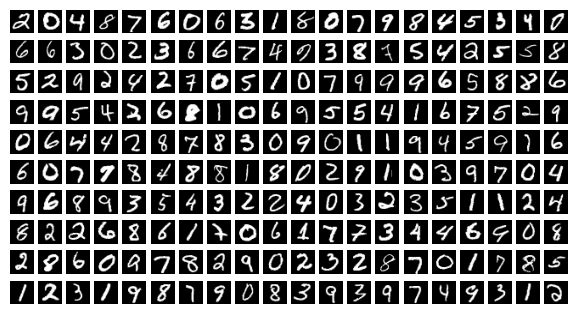

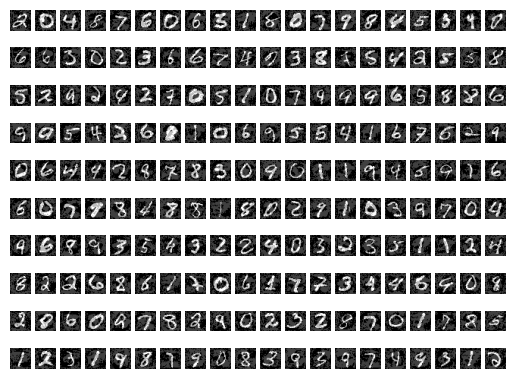

time: 8.43 s (started: 2022-12-12 16:01:21 +01:00)


In [83]:
#Afficher les images
import matplotlib.pyplot as plt
plt.figure(figsize=(7.195, 3.841), dpi=100)
plt.figure(1)
for i in range(200):
  plt.subplot(10,20,i+1)
  plt.imshow(x_test[i,:].reshape([28,28]), cmap='gray')
  plt.axis('off')
plt.figure(2)
for i in range(200):
  plt.subplot(10,20,i+1)
  plt.imshow(x_test_adv[i,:].reshape([28,28]), cmap='gray')
  plt.axis('off')

plt.show()


In [84]:

class SequentialAdversarialLoss(tf.keras.Sequential):
    def __init__(self, *args, **kwargs):
        super(SequentialAdversarialLoss, self).__init__(*args, **kwargs)
        self.alpha = 0.5
        self.a = []
        self.eps = 0.25
    
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data
        """for i in x:
            print(x)
        print(tf.identity(x))
        dataset = tf.data.Dataset.from_tensor_slices((tf.expand_dims(tf.identity(x),0),tf.expand_dims(tf.identity(y),0)))
        print(dataset)
        print("-------------------")
        adv_x = get_adversial_exemple(self,dataset,0.25)
        print("++++++++++++++++++++++")"""

        with tf.GradientTape(persistent=True) as tape:
            tape.watch(x)
            #tape.watch(adv_x)
            y_pred = self(x, training=True)  # Forward pass
            
            #adv_y_pred = self(adv_x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(y, y_pred)
            
        gradient = tape.gradient(loss, x)
        signed_grad = tf.sign(gradient)
        x_adv = x + 0.25 * signed_grad
        x_adv = tf.clip_by_value(x_adv, 0, 1)
        
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(x_adv)
            y_pred_adv = self(x_adv, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss *= self.alpha 
            loss += (1 - self.alpha) * self.compiled_loss(y, y_pred_adv)
            
            
        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        del tape
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value

        return {m.name: m.result() for m in self.metrics}
    

time: 2.18 ms (started: 2022-12-12 16:01:29 +01:00)


In [91]:
# Shallow maxout model inspired from https://github.com/philipperemy/tensorflow-maxout/blob/master/mnist_maxout_example.py

shallow_maxout = SequentialAdversarialLoss([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(960),
  tfa.layers.Maxout(240),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(10, activation='softmax'),
])

shallow_maxout.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

shallow_maxout.fit(ds_train, epochs=10)

print("------------------Train dataset-------------")
shallow_maxout.evaluate(ds_train) 
x_train_adv = get_adversial_exemple(shallow_maxout, ds_train, eps=0.25)
_, accuracy =  shallow_maxout.evaluate(x_train_adv, y_train, verbose = 0)
confidence = np.mean(np.max(shallow_maxout.predict(x_train_adv, verbose = 0), axis=1))
print(f"Accuracy on adversarial examples: {accuracy} with a mean confidence of {confidence}", )
print("------------------Test dataset-------------")
shallow_maxout.evaluate(ds_test) 
x_test_adv = get_adversial_exemple(shallow_maxout, ds_test, eps=0.25)
loss, accuracy =  shallow_maxout.evaluate(x_test_adv, y_test, verbose = 0)
confidence = np.mean(np.max(shallow_maxout.predict(x_test_adv, verbose = 0), axis=1))
print(f"Accuracy on adversarial examples: {accuracy} with a mean confidence of {confidence}", )

Epoch 1/10
469/469 [==============================] - 9s 17ms/step - loss: 1.3041 - accuracy: 0.7883
Epoch 2/10
469/469 [==============================] - 8s 17ms/step - loss: 0.7299 - accuracy: 0.8191
Epoch 3/10
469/469 [==============================] - 8s 17ms/step - loss: 0.6020 - accuracy: 0.8172
Epoch 4/10
469/469 [==============================] - 8s 17ms/step - loss: 0.5737 - accuracy: 0.8164
Epoch 5/10
469/469 [==============================] - 8s 17ms/step - loss: 0.5478 - accuracy: 0.8193
Epoch 6/10
469/469 [==============================] - 8s 17ms/step - loss: 0.5332 - accuracy: 0.8210
Epoch 7/10
469/469 [==============================] - 8s 17ms/step - loss: 0.5305 - accuracy: 0.8284
Epoch 8/10
469/469 [==============================] - 8s 17ms/step - loss: 0.5364 - accuracy: 0.8307
Epoch 9/10
469/469 [==============================] - 8s 17ms/step - loss: 0.5262 - accuracy: 0.8388
Epoch 10/10
469/469 [==============================] - 8s 17ms/step - loss: 0.5109 - accura

In [90]:
shallow_maxout = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(960),
  tfa.layers.Maxout(240),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(10, activation='softmax'),
])

shallow_maxout.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

shallow_maxout.fit(ds_train, epochs=10)

print("------------------Train dataset-------------")
shallow_maxout.evaluate(ds_train) 
x_train_adv = get_adversial_exemple(shallow_maxout, ds_train, eps=0.25)
_, accuracy =  shallow_maxout.evaluate(x_train_adv, y_train, verbose = 0)
confidence = np.mean(np.max(shallow_maxout.predict(x_train_adv, verbose = 0), axis=1))
print(f"Accuracy on adversarial examples: {accuracy} with a mean confidence of {confidence}", )
print("------------------Test dataset-------------")
shallow_maxout.evaluate(ds_test) 
x_test_adv = get_adversial_exemple(shallow_maxout, ds_test, eps=0.25)
loss, accuracy =  shallow_maxout.evaluate(x_test_adv, y_test, verbose = 0)
confidence = np.mean(np.max(shallow_maxout.predict(x_test_adv, verbose = 0), axis=1))
print(f"Accuracy on adversarial examples: {accuracy} with a mean confidence of {confidence}", )

Epoch 1/10
469/469 [==============================] - 6s 11ms/step - loss: 0.2804 - accuracy: 0.9184
Epoch 2/10
469/469 [==============================] - 5s 11ms/step - loss: 0.1212 - accuracy: 0.9639
Epoch 3/10
469/469 [==============================] - 5s 11ms/step - loss: 0.0899 - accuracy: 0.9730
Epoch 4/10
469/469 [==============================] - 5s 11ms/step - loss: 0.0753 - accuracy: 0.9769
Epoch 5/10
469/469 [==============================] - 5s 11ms/step - loss: 0.0672 - accuracy: 0.9790
Epoch 6/10
469/469 [==============================] - 5s 11ms/step - loss: 0.0563 - accuracy: 0.9819
Epoch 7/10
469/469 [==============================] - 5s 11ms/step - loss: 0.0506 - accuracy: 0.9843
Epoch 8/10
469/469 [==============================] - 5s 11ms/step - loss: 0.0463 - accuracy: 0.9852
Epoch 9/10
469/469 [==============================] - 5s 11ms/step - loss: 0.0417 - accuracy: 0.9862
Epoch 10/10
469/469 [==============================] - 5s 11ms/step - loss: 0.0404 - accura